Качаем тестовый датасет

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, shutil

ZIP_ON_DRIVE = "/content/drive/MyDrive/test.zip"
WORKDIR = "/content/work"
os.makedirs(WORKDIR, exist_ok=True)

zip_local = os.path.join(WORKDIR, "test.zip")
shutil.copy2(ZIP_ON_DRIVE, zip_local)

print("Copied to:", zip_local, "| size:", os.path.getsize(zip_local), "bytes")


Copied to: /content/work/test.zip | size: 688051860 bytes


In [3]:
import zipfile

WORKDIR = "/content/work"
zip_local = os.path.join(WORKDIR, "test.zip")
EXTRACT_DIR = os.path.join(WORKDIR, "test")

os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(zip_local, 'r') as z:
    z.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)
print("Top-level items:", os.listdir(EXTRACT_DIR)[:20])


Extracted to: /content/work/test
Top-level items: ['images', 'gt']


Теперь прогоним на нем нашу модель сегментации

In [12]:
# ============================================================
# Полный пайплайн инференса модели сегментации зданий на тесте
# - Читает датасет: /content/work/test/images и /content/work/test/gt
# - Поддерживает PNG/JPG/TIF
# - Делает 5 прогонов на разных GSD: 0.1, 0.2, 0.3, 0.4, 0.5
#   Оригинальный снимок в GSD=0.3
#   Остальные масштабы получаем:
#     - апскейл (scale>1): кубическая интерполяция (cubic)
#     - даунскейл (scale<1): интерполяция area
#   Маску GT рескейлим отдельно:
#     - апскейл: nearest
#     - даунскейл: area + порог 0.5
# - Тайловый инференс:
#     tile_size=256, overlap=50% -> stride=128
# - Порог бинаризации предсказания: 0.86
# - Считает для каждого (файл, gsd):
#     IoU, площадь GT в пикселях, площадь предсказания в пикселях
# - Сохраняет CSV с результатами и сводку по GSD
# - Путь к весам задан:
#   /content/drive/MyDrive/Models/best_unet.pt
# ============================================================

# ----------------------------
# Установка зависимостей
# ----------------------------
!pip -q install opencv-python-headless pandas tqdm rasterio

import os
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

# ============================================================
# Параметры путей и датасета
# ============================================================

# Корень распакованного теста
DATA_ROOT = "/content/work/test"

# Папки датасета (как у вас на скриншотах)
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
GT_DIR     = os.path.join(DATA_ROOT, "gt")

assert os.path.isdir(IMAGES_DIR), f"Не найдена папка images: {IMAGES_DIR}"
assert os.path.isdir(GT_DIR), f"Не найдена папка gt: {GT_DIR}"

# Жестко заданный путь к модели (как вы попросили)
WEIGHTS_PATH = "/content/drive/MyDrive/Models/best_unet.pt"
assert os.path.exists(WEIGHTS_PATH), f"Не найден файл весов: {WEIGHTS_PATH}"

# ============================================================
# Гиперпараметры инференса/оценки
# ============================================================

# Порог для бинаризации вероятностей
THRESHOLD = 0.86

# Тайлы и оверлап
TILE_SIZE = 256
OVERLAP = 0.50
STRIDE = int(TILE_SIZE * (1 - OVERLAP))  # 128

# GSD
ORIG_GSD = 0.3
TARGET_GSDS = [0.1, 0.2, 0.3, 0.4, 0.5]

# ============================================================
# Модель
# ============================================================

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResNet50UNet(nn.Module):
    """
    1:1 с вашим кодом.
    Возвращает {"out": logits}
    logits shape: [B,1,H,W]
    """
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = resnet50(weights=None)
        self.encoder.fc = nn.Identity()

        self.enc0 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu)  # /2, 64
        self.pool = self.encoder.maxpool                                                  # /4
        self.enc1 = self.encoder.layer1                                                    # /4, 256
        self.enc2 = self.encoder.layer2                                                    # /8, 512
        self.enc3 = self.encoder.layer3                                                    # /16, 1024
        self.enc4 = self.encoder.layer4                                                    # /32, 2048

        self.dec4 = UNetDecoderBlock(in_ch=2048, skip_ch=1024, out_ch=512)  # /16
        self.dec3 = UNetDecoderBlock(in_ch=512,  skip_ch=512,  out_ch=256)  # /8
        self.dec2 = UNetDecoderBlock(in_ch=256,  skip_ch=256,  out_ch=128)  # /4
        self.dec1 = UNetDecoderBlock(in_ch=128,  skip_ch=64,   out_ch=64)   # /2

        self.head = nn.Sequential(
            ConvBNReLU(64, 32),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x0 = self.enc0(x)             # /2
        x1 = self.enc1(self.pool(x0)) # /4
        x2 = self.enc2(x1)            # /8
        x3 = self.enc3(x2)            # /16
        x4 = self.enc4(x3)            # /32

        d4 = self.dec4(x4, x3)
        d3 = self.dec3(d4, x2)
        d2 = self.dec2(d3, x1)
        d1 = self.dec1(d2, x0)

        out = F.interpolate(d1, size=x.shape[-2:], mode="bilinear", align_corners=False)
        out = self.head(out)          # [B,1,H,W]
        return {"out": out}

# ============================================================
# Конфиг и кэш модели
# ============================================================

@dataclass
class BuildingSegConfig:
    weights_path: str = WEIGHTS_PATH
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    use_amp: bool = True
    pad_mode: str = "reflect"  # "reflect" — естественный паддинг краёв

_MODEL: Optional[nn.Module] = None
_MODEL_CFG: Optional[BuildingSegConfig] = None

def _get_model(cfg: BuildingSegConfig) -> nn.Module:
    """
    Загружает модель один раз и держит её в памяти (и на GPU).
    Чекпойнт ожидается либо как:
      {"model_state_dict": ...}
    либо прямо state_dict.
    """
    global _MODEL, _MODEL_CFG

    if _MODEL is not None and _MODEL_CFG is not None:
        if os.path.abspath(_MODEL_CFG.weights_path) == os.path.abspath(cfg.weights_path):
            return _MODEL

    if not os.path.exists(cfg.weights_path):
        raise FileNotFoundError(f"Не найден checkpoint: {cfg.weights_path}")

    model = ResNet50UNet(num_classes=1)

    ckpt = torch.load(cfg.weights_path, map_location="cpu")
    state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

    # На случай сохранения DataParallel (module. префикс)
    if isinstance(state, dict) and any(k.startswith("module.") for k in state.keys()):
        state = {k.replace("module.", "", 1): v for k, v in state.items()}

    model.load_state_dict(state, strict=True)
    model.to(cfg.device)
    model.eval()

    _MODEL = model
    _MODEL_CFG = cfg
    return model

def _preprocess_tile(tile_rgb: np.ndarray) -> torch.Tensor:
    """
    Препроцессинг как в вашем коде:
    - перевод в float
    - нормализация в диапазон 0..1
    - без mean/std
    """
    x = tile_rgb.astype(np.float32)

    # На случай, если вдруг попадется uint16
    if x.max() > 255.0:
        x = x / 65535.0
    else:
        x = x / 255.0

    x = np.transpose(x, (2, 0, 1))           # [3,H,W]
    x = torch.from_numpy(x).unsqueeze(0)     # [1,3,H,W]
    return x

@torch.no_grad()
def _predict_prob_mask_tiled(
    image_rgb: np.ndarray,
    model: nn.Module,
    cfg: BuildingSegConfig,
    tile_size: int,
    stride: int,
) -> Tuple[np.ndarray, Dict]:
    """
    Возвращает prob_mask float32 [H,W] в [0..1]
    Склейка по overlap: sum/count (усреднение)
    """
    H, W, _ = image_rgb.shape
    sum_map = np.zeros((H, W), dtype=np.float32)
    cnt_map = np.zeros((H, W), dtype=np.float32)

    tiles_count = 0
    tile_size = int(tile_size)
    stride = int(stride)

    amp_enabled = cfg.use_amp and cfg.device.startswith("cuda")

    for y0 in range(0, H, stride):
        for x0 in range(0, W, stride):
            y1 = min(y0 + tile_size, H)
            x1 = min(x0 + tile_size, W)

            tile = image_rgb[y0:y1, x0:x1]

            # Допаддинг тайла до tile_size
            pad_bottom = tile_size - (y1 - y0)
            pad_right  = tile_size - (x1 - x0)

            if pad_bottom > 0 or pad_right > 0:
                tile = np.pad(
                    tile,
                    ((0, pad_bottom), (0, pad_right), (0, 0)),
                    mode=cfg.pad_mode,
                )

            x = _preprocess_tile(tile).to(cfg.device, non_blocking=True)

            # Автокаст для ускорения на GPU
            autocast_ctx = (
                torch.amp.autocast("cuda", dtype=torch.float16, enabled=True)
                if amp_enabled else
                torch.amp.autocast("cpu", enabled=False)
            )

            with autocast_ctx:
                logits = model(x)["out"]               # [1,1,tile,tile]
                probs  = torch.sigmoid(logits)[0, 0]   # [tile,tile]

            prob_np = probs.float().cpu().numpy()

            # Возвращаемся к исходному окну (если был паддинг)
            prob_np = prob_np[: (y1 - y0), : (x1 - x0)]

            sum_map[y0:y1, x0:x1] += prob_np
            cnt_map[y0:y1, x0:x1] += 1.0

            tiles_count += 1

    prob_mask = sum_map / np.maximum(cnt_map, 1e-6)

    debug = {
        "tiles_count": tiles_count,
        "image_hw": [int(H), int(W)],
        "tile_size": tile_size,
        "stride": stride,
        "device": cfg.device,
        "use_amp": bool(amp_enabled),
    }
    return prob_mask.astype(np.float32), debug

def predict_building_mask(
    image_rgb: np.ndarray,
    cfg: BuildingSegConfig,
    tile_size: int,
    stride: int,
    threshold: float,
) -> Tuple[np.ndarray, Dict]:
    """
    Возвращает бинарную маску (0/1) и debug-словарь.
    """
    model = _get_model(cfg)
    prob_mask, debug = _predict_prob_mask_tiled(
        image_rgb=image_rgb,
        model=model,
        cfg=cfg,
        tile_size=tile_size,
        stride=stride,
    )

    thr = float(threshold)
    bin_mask = (prob_mask >= thr).astype(np.uint8)

    debug.update({
        "threshold": thr,
        "prob_min": float(prob_mask.min()),
        "prob_max": float(prob_mask.max()),
        "prob_mean": float(prob_mask.mean()),
        "pred_area_px": int(bin_mask.sum()),
        "weights_path": cfg.weights_path,
    })

    return bin_mask, debug

# ============================================================
# Загрузка изображений/масок (PNG/JPG/TIF)
# ============================================================

def list_images(folder: str) -> List[str]:
    """
    Сканирует папку и возвращает список файлов изображений по расширениям.
    (В вашем датасете это PNG.)
    """
    exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff")
    files = []
    for f in os.listdir(folder):
        if f.lower().endswith(exts):
            files.append(os.path.join(folder, f))
    return sorted(files)

def load_image_rgb(path: str) -> np.ndarray:
    """
    Загружает изображение как RGB uint8/uint16.
    OpenCV по умолчанию читает BGR, поэтому конвертируем в RGB.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)

    # Если есть альфа-канал — отрезаем его
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]

    # Если grayscale — делаем 3 канала
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_mask_bin(path: str) -> np.ndarray:
    """
    Загружает GT-маску и делает бинарной (0/1).
    """
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(path)
    m = (m > 0).astype(np.uint8)
    return m

# ============================================================
# Рескейл под разные GSD
# ============================================================

def resize_for_gsd(img: np.ndarray, mask: np.ndarray, target_gsd: float) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Меняет масштаб изображения и маски под target_gsd.
    scale = ORIG_GSD / target_gsd

    Изображение:
      - scale>1 (апскейл): cubic
      - scale<1 (даунскейл): area

    Маска:
      - scale>1 (апскейл): nearest
      - scale<1 (даунскейл): area + порог 0.5
    """
    h, w = img.shape[:2]
    scale = ORIG_GSD / float(target_gsd)

    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))

    if scale > 1.0:
        # Апскейл
        img_r = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        m_r   = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        m_r = (m_r > 0).astype(np.uint8)

    elif scale < 1.0:
        # Даунскейл
        img_r = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        m_f   = cv2.resize(mask.astype(np.float32), (new_w, new_h), interpolation=cv2.INTER_AREA)
        m_r   = (m_f >= 0.5).astype(np.uint8)

    else:
        # Оригинальный масштаб
        img_r, m_r = img, mask

    return img_r, m_r, scale

# ============================================================
# Метрика IoU
# ============================================================

def iou_score(pred: np.ndarray, gt: np.ndarray) -> float:
    """
    IoU для бинарных масок.
    Если обе маски пустые -> IoU=1.0
    """
    pred = (pred > 0).astype(np.uint8)
    gt   = (gt > 0).astype(np.uint8)

    inter = int((pred & gt).sum())
    union = int((pred | gt).sum())

    if union == 0:
        return 1.0
    return inter / union

# ============================================================
# Основной прогон по датасету
# ============================================================

# Собираем список изображений
img_paths = list_images(IMAGES_DIR)
assert len(img_paths) > 0, f"В {IMAGES_DIR} нет изображений (.png/.jpg/.tif)"

print("Найдено изображений:", len(img_paths))
print("Пример файла:", os.path.basename(img_paths[0]))

# Конфиг модели
cfg = BuildingSegConfig(weights_path=WEIGHTS_PATH)

rows = []

for img_path in tqdm(img_paths, desc="Прогон датасета"):
    fname = os.path.basename(img_path)
    gt_path = os.path.join(GT_DIR, fname)
    if not os.path.exists(gt_path):
        raise FileNotFoundError(f"Не найдена GT-маска для {fname}: {gt_path}")

    # Загружаем оригинал (считаем, что он соответствует GSD=0.3)
    img0 = load_image_rgb(img_path)
    gt0  = load_mask_bin(gt_path)

    for gsd in TARGET_GSDS:
        # Рескейлим под заданный GSD
        img_g, gt_g, scale = resize_for_gsd(img0, gt0, gsd)

        # Инференс тайлами
        pred_g, dbg = predict_building_mask(
            image_rgb=img_g,
            cfg=cfg,
            tile_size=TILE_SIZE,
            stride=STRIDE,
            threshold=THRESHOLD,
        )

        # Метрики
        iou = iou_score(pred_g, gt_g)
        gt_area_px   = int(gt_g.sum())
        pred_area_px = int(pred_g.sum())

        rows.append({
            "file": fname,
            "gsd": float(gsd),
            "scale_from_0p3": float(scale),
            "H": int(img_g.shape[0]),
            "W": int(img_g.shape[1]),
            "gt_area_px": gt_area_px,
            "pred_area_px": pred_area_px,
            "iou": float(iou),
            "tiles_count": int(dbg["tiles_count"]),
            "prob_mean": float(dbg["prob_mean"]),
            "threshold": float(THRESHOLD),
            "tile_size": int(TILE_SIZE),
            "stride": int(STRIDE),
        })

# Результаты в DataFrame
df = pd.DataFrame(rows)
df.head()

# ============================================================
# Сохранение результатов
# ============================================================

OUT_DIR = "/content/work/gsd_eval"
os.makedirs(OUT_DIR, exist_ok=True)

csv_path = os.path.join(OUT_DIR, "results_per_image_per_gsd.csv")
df.to_csv(csv_path, index=False)
print("Сохранено:", csv_path)

# Сводка по GSD
summary = df.groupby("gsd").agg(
    n=("file", "count"),
    mean_iou=("iou", "mean"),
    median_iou=("iou", "median"),
    mean_gt_area=("gt_area_px", "mean"),
    mean_pred_area=("pred_area_px", "mean"),
).reset_index()

sum_path = os.path.join(OUT_DIR, "summary_by_gsd.csv")
summary.to_csv(sum_path, index=False)
print("Сохранено:", sum_path)

summary

Найдено изображений: 62
Пример файла: bellingham10_q00.png


Прогон датасета: 100%|██████████| 62/62 [1:09:07<00:00, 66.89s/it]

Сохранено: /content/work/gsd_eval/results_per_image_per_gsd.csv
Сохранено: /content/work/gsd_eval/summary_by_gsd.csv


gsd   n  mean_iou  median_iou  mean_gt_area  mean_pred_area
0  0.1  62  0.392074    0.401918  4.018738e+06    2.207047e+06
1  0.2  62  0.765171    0.776380  1.004683e+06    9.416987e+05
2  0.3  62  0.767499    0.790940  4.465264e+05    4.595002e+05
3  0.4  62  0.759441    0.777053  2.532133e+05    2.525190e+05
4  0.5  62  0.744977    0.764706  1.606603e+05    1.603028e+05

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os

def show_prediction(file_name: str, gsd: float = 0.3, alpha: float = 0.45):
    """
    Визуализация для одного файла:
    - изображение (RGB)
    - GT маска
    - предсказанная маска
    - оверлей (предсказание поверх изображения)
    """
    img_path = os.path.join(IMAGES_DIR, file_name)
    gt_path  = os.path.join(GT_DIR, file_name)

    assert os.path.exists(img_path), f"Нет файла изображения: {img_path}"
    assert os.path.exists(gt_path), f"Нет файла GT: {gt_path}"

    img0 = load_image_rgb(img_path)
    gt0  = load_mask_bin(gt_path)

    img_g, gt_g, scale = resize_for_gsd(img0, gt0, gsd)

    pred_g, dbg = predict_building_mask(
        image_rgb=img_g,
        cfg=cfg,
        tile_size=TILE_SIZE,
        stride=STRIDE,
        threshold=THRESHOLD,
    )

    # IoU для подписи
    iou = iou_score(pred_g, gt_g)

    # Оверлей
    overlay = img_g.copy()
    red = np.zeros_like(img_g)
    red[..., 0] = 255  # красный в RGB
    mask3 = pred_g.astype(bool)
    overlay[mask3] = (alpha * red[mask3] + (1 - alpha) * overlay[mask3]).astype(np.uint8)

    # Рисуем
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.title(f"Изображение | {file_name}\nGSD={gsd}, scale={scale:.3f}")
    plt.imshow(img_g)
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.title(f"GT маска | площадь={int(gt_g.sum())} px")
    plt.imshow(gt_g, cmap="gray")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.title(f"Pred маска | thr={THRESHOLD} | площадь={int(pred_g.sum())} px")
    plt.imshow(pred_g, cmap="gray")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.title(f"Overlay pred | IoU={iou:.4f}")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

проверим худшие снимки

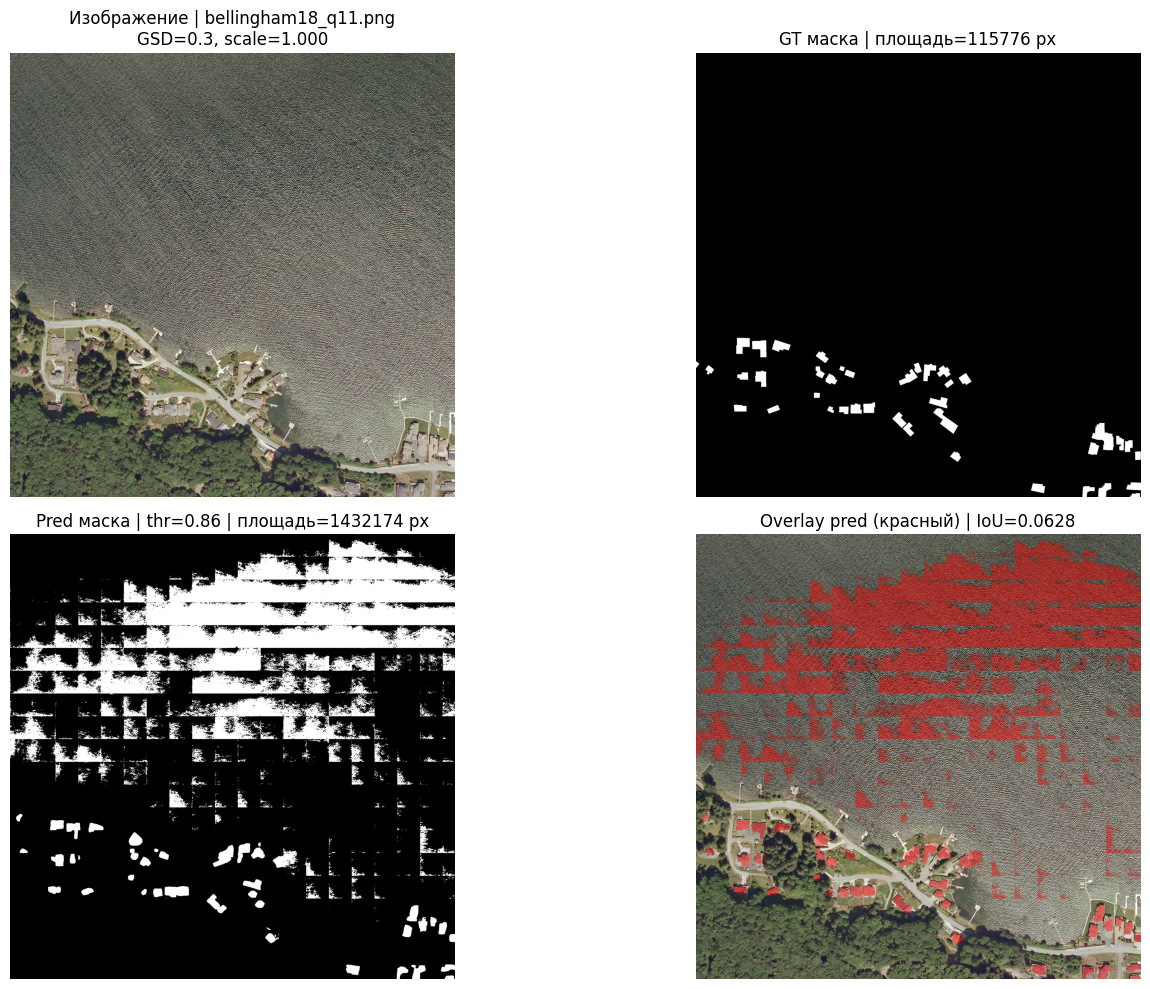

In [16]:
show_prediction("bellingham18_q11.png", gsd=0.3)

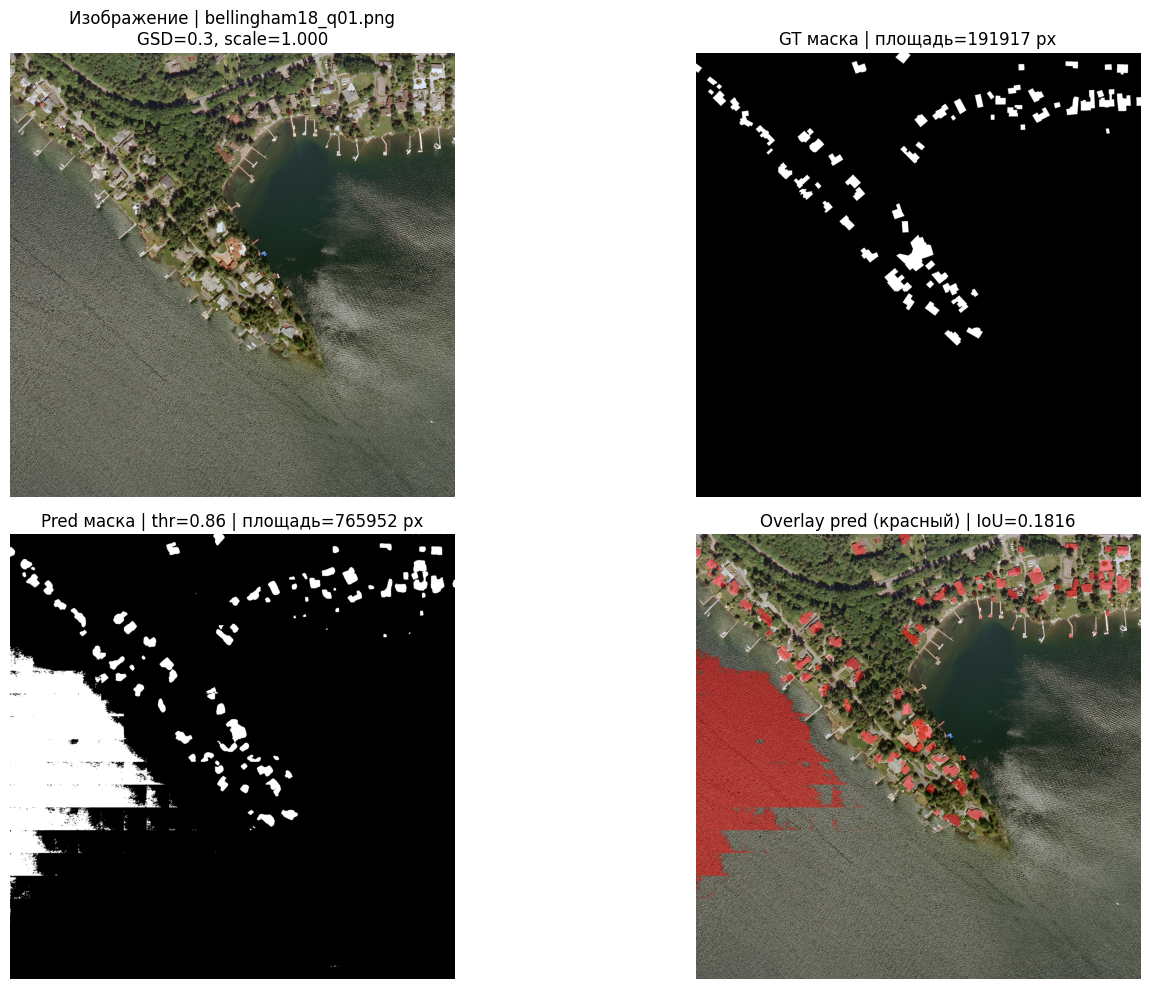

In [17]:
show_prediction("bellingham18_q01.png", gsd=0.3)

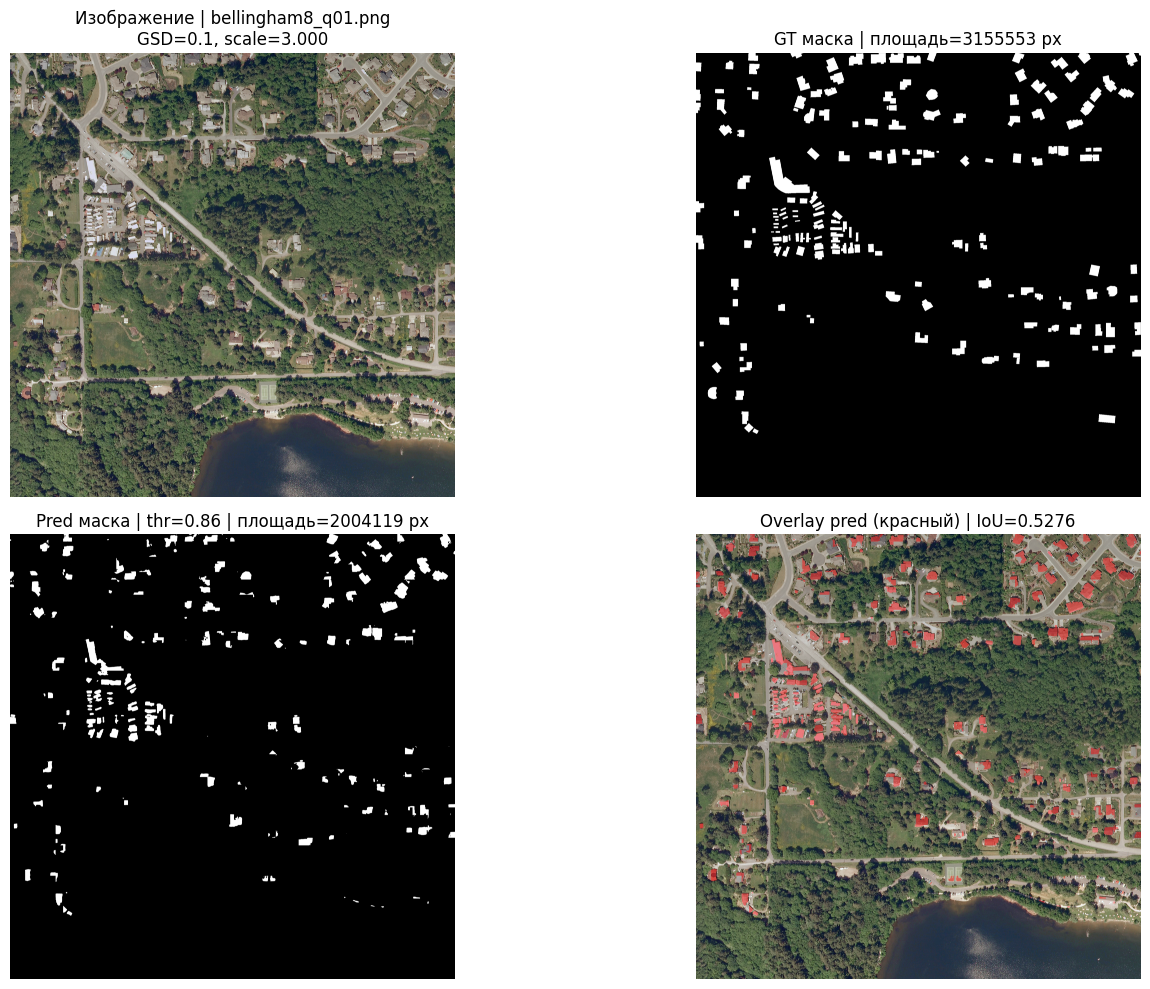

In [18]:
show_prediction("bellingham8_q01.png", gsd=0.1)

По полученным результатам видно, что наихужшие результаты получаются на GSD 0,1. Для модели это слишком близкий масштаб. На масштабах от 0,2 до 0,5 результаты в целом удовлетворительные. Лучший результат на оригинальном масштабе 0,3, на котором и была обучена модель.
Также было замечено что на двух снимках с водой модель приняла её за здания изза похожей текстуры и цвета. Другие снимки с водой обработаны нормально.

Теперь прогоним модель определения масштаба на всех снимках

In [20]:
# ============================================================
# Прогон модели определения GSD (YOLO-OBB) на всём датасете
# ------------------------------------------------------------
# 1) Берём исходные изображения из /content/work/test/images
# 2) Для каждого изображения делаем 5 рескейлов под GSD:
#       0.1, 0.2, 0.3, 0.4, 0.5
#    Оригинал считается GSD=0.3.
#    - Апскейл изображения: cubic
#    - Даунскейл изображения: area
# 3) Запускает модель определения масштаба (YOLO OBB) на каждом варианте
#    (веса скачиваются автоматически через ultralytics).
# 4) Собираем таблицу:
#    - file
#    - gsd_true (реальный)
#    - gsd_pred (предсказанный)
#    - abs_pct_error (процентное отклонение по модулю)
#    - signed_pct_error (со знаком)
#    - status (ok / not_enough_cars / ...)
#    - вспомогательная диагностика (сколько машин найдено и т.д.)
#
# ВАЖНО:
# - Изображения в датасете PNG
# - Если на каких-то масштабах машин мало, функция вернёт None
#   Тогда в таблице будет status != "ok".
# ============================================================

# ----------------------------
# Установка зависимостей
# ----------------------------
!pip -q install ultralytics opencv-python-headless pandas tqdm

import os
import math
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from ultralytics import YOLO

# ============================================================
# Пути к данным
# ============================================================

DATA_ROOT = "/content/work/test"
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
GT_DIR     = os.path.join(DATA_ROOT, "gt")  # для этой задачи не обязателен, но оставляем

assert os.path.isdir(IMAGES_DIR), f"Не найдена папка images: {IMAGES_DIR}"
assert os.path.isdir(GT_DIR), f"Не найдена папка gt: {GT_DIR}"

# ============================================================
# Параметры прогонов
# ============================================================

# Тайлы и оверлап
TILE_SIZE = 1024
OVERLAP = 0.10
STRIDE = int(TILE_SIZE * (1 - OVERLAP))

# GSD
ORIG_GSD = 0.3
TARGET_GSDS = [0.1, 0.2, 0.3, 0.4, 0.5]

# ============================================================
# Утилиты для чтения изображений + рескейл под GSD
# ============================================================

def list_images(folder: str) -> List[str]:
    """Список файлов изображений по расширениям."""
    exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff")
    out = []
    for f in os.listdir(folder):
        if f.lower().endswith(exts):
            out.append(os.path.join(folder, f))
    return sorted(out)

def load_image_rgb(path: str) -> np.ndarray:
    """
    Загружает изображение в RGB.
    OpenCV читает BGR, поэтому переводим в RGB.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)

    # Если есть альфа-канал — убираем
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]

    # Если grayscale — делаем 3 канала
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def resize_image_for_gsd(img: np.ndarray, target_gsd: float) -> Tuple[np.ndarray, float]:
    """
    Рескейл изображения под target_gsd.
    scale = ORIG_GSD / target_gsd

    Апскейл (scale>1): cubic
    Даунскейл (scale<1): area
    """
    h, w = img.shape[:2]
    scale = ORIG_GSD / float(target_gsd)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))

    if scale > 1.0:
        img_r = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    elif scale < 1.0:
        img_r = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        img_r = img

    return img_r, scale

# ============================================================
# Конфиг модели определения масштаба (как в приложении)
# ============================================================

@dataclass
class CarScaleConfig:

    model_ref: str = "yolo26x-obb.pt"   # веса должны скачаться автоматически

    car_class_id: int = 10

    # адаптивные пороги
    conf_primary: float = 0.10
    conf_fallback: float = 0.01

    # минимум машин для принятия результата
    min_cars_primary: int = 6
    min_cars_fallback: int = 4

    iou_thres_tile: float = 0.50
    merge_cell_px: int = 3

    # батчинг тайлов
    tile_batch: int = 16

    half: bool = True
    device: Optional[str] = None  # None=auto, или "cuda:0", "cpu"

    # +2% upscale перед детекцией
    pre_upscale: float = 1.02

    # фильтры (box похож на машину)
    aspect_ratio_min: float = 1.2
    aspect_ratio_max: float = 3.8
    iqr_k: float = 1.5
    iqr_min_n: int = 6

    # S1 базовая формула
    target_sqrtlw_m: float = 3.212

    # log-calib coefficients
    a: float = 0.11032050
    b: float = 1.02631206
    c: float = -0.01989536
    d: float = -0.00519021

    # shift
    k_shift: float = 0.9986315218974585

# ============================================================
# Глобальный кэш YOLO модели
# ============================================================

_MODEL: Optional[YOLO] = None
_MODEL_REF: Optional[str] = None

def _resolve_model_ref(cfg: CarScaleConfig) -> str:
    """
    Если передано только имя, и есть локальный weights/имя — используем локальный.
    Иначе оставляем как есть: ultralytics скачает автоматически.
    """
    ref = cfg.model_ref
    if os.path.sep not in ref and "/" not in ref:
        local_candidate = os.path.join("weights", ref)
        if os.path.exists(local_candidate) and os.path.getsize(local_candidate) > 0:
            return local_candidate
    return ref

def _get_model(cfg: CarScaleConfig) -> YOLO:
    """Загружает модель один раз (ultralytics сам скачает/кэширует веса)."""
    global _MODEL, _MODEL_REF
    ref = _resolve_model_ref(cfg)

    if _MODEL is not None and _MODEL_REF == ref:
        return _MODEL

    model = YOLO(ref)
    _MODEL = model
    _MODEL_REF = ref
    return model

# ============================================================
# Тайлинг
# ============================================================

def _generate_tiles_with_stride(img_bgr: np.ndarray, tile_size: int, stride: int):
    """
    Генератор тайлов с паддингом до tile_size (черным фоном).
    Возвращает координаты и сам тайл.
    """
    H, W = img_bgr.shape[:2]
    tile_size = int(tile_size)
    stride = int(stride)

    xs = list(range(0, W, stride))
    ys = list(range(0, H, stride))

    for y0 in ys:
        for x0 in xs:
            x1 = min(x0 + tile_size, W)
            y1 = min(y0 + tile_size, H)

            tile = img_bgr[y0:y1, x0:x1]
            pad_right = tile_size - (x1 - x0)
            pad_bottom = tile_size - (y1 - y0)

            if pad_right > 0 or pad_bottom > 0:
                tile = cv2.copyMakeBorder(
                    tile, 0, pad_bottom, 0, pad_right,
                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)
                )

            yield (x0, y0, x1, y1, tile)

# ============================================================
# Извлечение OBB детекций + мердж дублей
# ============================================================

def _extract_detections_xywhr(result, keep_class_id: Optional[int] = None) -> List[Dict]:
    """
    Достаёт OBB детекции в формате xywhr (центр, размеры, угол).
    """
    dets = []
    if not hasattr(result, "obb") or result.obb is None:
        return dets

    obb = result.obb
    boxes = obb.xywhr.cpu().numpy()  # (N,5): cx,cy,w,h,angle
    conf = obb.conf.cpu().numpy() if hasattr(obb, "conf") else None
    cls  = obb.cls.cpu().numpy().astype(int) if hasattr(obb, "cls") else None

    n = boxes.shape[0]
    for i in range(n):
        c = int(cls[i]) if cls is not None else -1
        if keep_class_id is not None and c != keep_class_id:
            continue

        dets.append({
            "cx": float(boxes[i, 0]),
            "cy": float(boxes[i, 1]),
            "w":  float(boxes[i, 2]),
            "h":  float(boxes[i, 3]),
            "angle": float(boxes[i, 4]),
            "conf": float(conf[i]) if conf is not None else 0.0,
            "cls": c
        })

    return dets

def _merge_xywhr_by_center_hash(detections: List[Dict], cell: int = 12) -> List[Dict]:
    """
    Простое объединение дублей: хэшируем по сетке центров и оставляем лучший по conf.
    """
    if not detections:
        return []

    best = {}  # (gx,gy) -> det

    for d in detections:
        gx = int(d["cx"] // cell)
        gy = int(d["cy"] // cell)

        winner_key = None
        winner_conf = -1.0

        for dx in (-1, 0, 1):
            for dy in (-1, 0, 1):
                k = (gx + dx, gy + dy)
                if k in best and best[k]["conf"] > winner_conf:
                    winner_conf = best[k]["conf"]
                    winner_key = k

        if winner_key is None:
            best[(gx, gy)] = d
        else:
            if d["conf"] > best[winner_key]["conf"]:
                best[winner_key] = d

    return list(best.values())

# ============================================================
# Фильтры детекций (aspect ratio + IQR по sqrt(L*W))
# ============================================================

def _filter_by_aspect_ratio(dets: List[Dict], rmin: float, rmax: float) -> List[Dict]:
    if not dets:
        return []
    out = []
    for d in dets:
        w = float(d.get("w", 0.0))
        h = float(d.get("h", 0.0))
        if w <= 0 or h <= 0:
            continue
        L = max(w, h)
        W = min(w, h)
        if W <= 0:
            continue
        ratio = L / W
        if rmin <= ratio <= rmax:
            out.append(d)
    return out

def _filter_by_sqrtLW_iqr(dets: List[Dict], k: float, min_n: int) -> List[Dict]:
    """
    IQR фильтр по sqrt(L*W), чтобы убрать выбросы размеров боксов.
    Применяется только если детекций >= min_n.
    """
    if not dets or len(dets) < int(min_n):
        return dets

    w = np.array([d["w"] for d in dets], dtype=np.float32)
    h = np.array([d["h"] for d in dets], dtype=np.float32)

    L = np.maximum(w, h)
    W = np.minimum(w, h)
    s = np.sqrt(L * W)

    q1 = np.percentile(s, 25)
    q3 = np.percentile(s, 75)
    iqr = q3 - q1

    lo = q1 - k * iqr
    hi = q3 + k * iqr

    out = []
    for d in dets:
        Ld = max(float(d["w"]), float(d["h"]))
        Wd = min(float(d["w"]), float(d["h"]))
        sd = math.sqrt(max(Ld * Wd, 0.0))
        if lo <= sd <= hi:
            out.append(d)

    return out

def _apply_filters(dets: List[Dict], cfg: CarScaleConfig) -> List[Dict]:
    dets2 = _filter_by_aspect_ratio(dets, cfg.aspect_ratio_min, cfg.aspect_ratio_max)
    dets3 = _filter_by_sqrtLW_iqr(dets2, cfg.iqr_k, cfg.iqr_min_n)
    return dets3

# ============================================================
# Статистика + формула GSD (S1)
# ============================================================

def _compute_stats_pixels(dets: List[Dict]) -> Dict:
    if not dets:
        return {
            "median_length_px": np.nan,
            "median_width_px":  np.nan,
            "median_sqrtLW_px": np.nan,
            "count": 0,
        }

    w = np.array([d["w"] for d in dets], dtype=np.float32)
    h = np.array([d["h"] for d in dets], dtype=np.float32)

    lengths = np.maximum(w, h)
    widths  = np.minimum(w, h)
    sqrtLW  = np.sqrt(lengths * widths)

    return {
        "median_length_px": float(np.median(lengths)),
        "median_width_px":  float(np.median(widths)),
        "median_sqrtLW_px": float(np.median(sqrtLW)),
        "count": int(len(dets)),
    }

def _gsd_from_stats_s1(med_sqrtLW_px: float, count: int, H_px: int, W_px: int, cfg: CarScaleConfig) -> Tuple[float, Dict]:
    """
    Возвращает:
      - gsd_cal (м/пикс) после калибровки
      - debug-словарь с оценкой площади и нормализованным числом машин

    ВАЖНО:
    - Предварительный GSD (base) считаем по med_sqrtLW_px
    - Площадь кадра оцениваем по этому предварительному GSD и размеру кадра в пикселях
    - Количество машин нормируем к 2.25 км^2
    """

    eps = 1e-12

    # 1) Базовая оценка GSD (м/пикс) по размеру машин в пикселях
    gsd_pre = cfg.target_sqrtlw_m / float(med_sqrtLW_px)

    # 2) Оценка площади кадра по предварительному GSD
    #    площадь одного пикселя = gsd_pre^2 (м^2)
    area_m2 = float(H_px) * float(W_px) * float(gsd_pre ** 2)
    area_km2 = area_m2 / 1e6

    # 3) Нормируем число машин к 2.25 км^2
    #    N_2.25 = N / area_km2 * 2.25
    cars_per_2p25 = float(count) / max(area_km2, eps) * 2.25

    # 4) Лог-калибровка
    log_g = np.log(max(gsd_pre, 1e-9))
    # здесь важно: count теперь не целое, а плотность (float)
    log_c = np.log(max(cars_per_2p25, 1e-9))

    log_true = cfg.a + cfg.b * log_g + cfg.c * log_c + cfg.d * (log_g * log_c)
    gsd_cal = float(np.exp(log_true))

    # 5) shift
    gsd_cal *= cfg.k_shift

    debug = {
        "gsd_pre_m_per_px": float(gsd_pre),
        "area_m2_est": float(area_m2),
        "area_km2_est": float(area_km2),
        "cars_count_raw": int(count),
        "cars_per_2p25km2": float(cars_per_2p25),
    }
    return gsd_cal, debug

# ============================================================
# Детекция (батч тайлов)
# ============================================================

def _detect_image_tiled_batched(
    model: YOLO,
    img_bgr: np.ndarray,
    tile_size: int,
    stride: int,
    conf_thres: float,
    cfg: CarScaleConfig
) -> List[Dict]:
    """
    Детектит машины по тайлам, батчит тайлы для ускорения.
    Возвращает merged список детекций в координатах исходного изображения.
    """
    H, W = img_bgr.shape[:2]
    all_dets_global: List[Dict] = []

    batch_tiles_rgb: List[np.ndarray] = []
    batch_offsets: List[Tuple[int, int]] = []

    def run_batch():
        nonlocal batch_tiles_rgb, batch_offsets, all_dets_global
        if not batch_tiles_rgb:
            return

        results = model.predict(
            source=batch_tiles_rgb,
            imgsz=int(tile_size),
            conf=float(conf_thres),
            iou=float(cfg.iou_thres_tile),
            device=cfg.device,
            half=bool(cfg.half),
            classes=[int(cfg.car_class_id)],
            verbose=False
        )

        for r0, (x0, y0) in zip(results, batch_offsets):
            dets_tile = _extract_detections_xywhr(r0, keep_class_id=int(cfg.car_class_id))
            for d in dets_tile:
                cx = d["cx"] + x0
                cy = d["cy"] + y0
                if cx < 0 or cy < 0 or cx >= W or cy >= H:
                    continue
                all_dets_global.append({
                    "cx": cx, "cy": cy,
                    "w": d["w"], "h": d["h"],
                    "angle": d["angle"],
                    "conf": d["conf"],
                    "cls": d["cls"],
                })

        batch_tiles_rgb = []
        batch_offsets = []

    # Собираем тайлы
    for x0, y0, x1, y1, tile_bgr in _generate_tiles_with_stride(img_bgr, tile_size, stride):
        tile_rgb = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2RGB)
        batch_tiles_rgb.append(tile_rgb)
        batch_offsets.append((x0, y0))

        if len(batch_tiles_rgb) >= int(cfg.tile_batch):
            run_batch()

    # Добиваем остаток
    run_batch()

    # Мердж дублей
    merged = _merge_xywhr_by_center_hash(all_dets_global, cell=int(cfg.merge_cell_px))
    return merged

# ============================================================
# Публичная функция оценки GSD
# ============================================================

def estimate_gsd_from_cars(
    image_rgb: np.ndarray,
    tile_size: int,
    stride: int,
) -> Tuple[Optional[float], Dict]:
    """
    Вход:
      image_rgb uint8 [H,W,3]
    Выход:
      (gsd_m_per_px или None, stats dict)
    """
    cfg = CarScaleConfig()
    model = _get_model(cfg)

    # +2% upscale перед детекцией
    upscale = float(cfg.pre_upscale)
    if upscale <= 0:
        upscale = 1.0

    img_rgb = image_rgb
    if abs(upscale - 1.0) > 1e-9:
        H0, W0 = img_rgb.shape[:2]
        newW = max(1, int(round(W0 * upscale)))
        newH = max(1, int(round(H0 * upscale)))
        img_rgb = cv2.resize(img_rgb, (newW, newH), interpolation=cv2.INTER_CUBIC)

    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    Hs, Ws = img_bgr.shape[:2]

    # --- primary pass ---
    merged_primary_raw = _detect_image_tiled_batched(
        model=model,
        img_bgr=img_bgr,
        tile_size=int(tile_size),
        stride=int(stride),
        conf_thres=float(cfg.conf_primary),
        cfg=cfg,
    )
    merged_primary = _apply_filters(merged_primary_raw, cfg)
    st_primary = _compute_stats_pixels(merged_primary)

    used = "primary"
    conf_used = float(cfg.conf_primary)

    # --- fallback logic ---
    if int(st_primary["count"]) < int(cfg.min_cars_primary):
        merged_fallback_raw = _detect_image_tiled_batched(
            model=model,
            img_bgr=img_bgr,
            tile_size=int(tile_size),
            stride=int(stride),
            conf_thres=float(cfg.conf_fallback),
            cfg=cfg,
        )
        merged_fallback = _apply_filters(merged_fallback_raw, cfg)
        st_fallback = _compute_stats_pixels(merged_fallback)

        if int(st_fallback["count"]) >= int(cfg.min_cars_fallback):
            used = "fallback"
            conf_used = float(cfg.conf_fallback)
            st_used = st_fallback
            raw_count_used = len(merged_fallback_raw)
        else:
            # Машин недостаточно даже в fallback
            stats = {
                "gsd_status": "not_enough_cars",
                "used_pass": "none",
                "tile_size": int(tile_size),
                "stride": int(stride),
                "tile_batch": int(cfg.tile_batch),
                "pre_upscale": float(cfg.pre_upscale),
                "image_hw_upscaled": [int(Hs), int(Ws)],
                "conf_primary": float(cfg.conf_primary),
                "min_cars_primary": int(cfg.min_cars_primary),
                "primary_raw_count": int(len(merged_primary_raw)),
                "primary_count_after_filters": int(st_primary["count"]),
                "conf_fallback": float(cfg.conf_fallback),
                "min_cars_fallback": int(cfg.min_cars_fallback),
                "fallback_raw_count": int(len(merged_fallback_raw)),
                "fallback_count_after_filters": int(st_fallback["count"]),
                "model_ref": cfg.model_ref,
                "model_ref_resolved": _resolve_model_ref(cfg),
            }
            return None, stats
    else:
        st_used = st_primary
        raw_count_used = len(merged_primary_raw)

    # Общая статистика
    stats: Dict = {
        "gsd_status": "ok",
        "used_pass": used,
        "conf_used": float(conf_used),
        "tile_size": int(tile_size),
        "stride": int(stride),
        "tile_batch": int(cfg.tile_batch),
        "pre_upscale": float(cfg.pre_upscale),
        "image_hw_upscaled": [int(Hs), int(Ws)],
        "cars_raw_count": int(raw_count_used),
        "cars_count": int(st_used["count"]),
        "median_length_px": st_used["median_length_px"],
        "median_width_px": st_used["median_width_px"],
        "median_sqrtLW_px": st_used["median_sqrtLW_px"],
        "merge_cell_px": int(cfg.merge_cell_px),
        "iou_thres_tile": float(cfg.iou_thres_tile),
        "aspect_ratio_min": float(cfg.aspect_ratio_min),
        "aspect_ratio_max": float(cfg.aspect_ratio_max),
        "iqr_k": float(cfg.iqr_k),
        "iqr_min_n": int(cfg.iqr_min_n),
        "model_ref": cfg.model_ref,
        "model_ref_resolved": _resolve_model_ref(cfg),
    }

    # Санити-чек
    if st_used["count"] <= 0 or (not np.isfinite(st_used["median_sqrtLW_px"])) or st_used["median_sqrtLW_px"] <= 0:
        stats["gsd_status"] = "no_cars_detected_after_filters"
        return None, stats

    # GSD на апскейленном изображении
    gsd_upscaled, dbg_density = _gsd_from_stats_s1(
        med_sqrtLW_px=float(st_used["median_sqrtLW_px"]),
        count=int(st_used["count"]),
        H_px=int(Hs),
        W_px=int(Ws),
        cfg=cfg
    )

    # Возвращаемся к масштабу ДО pre_upscale (как и раньше)
    gsd_original = float(gsd_upscaled * upscale)

    stats.update({
        "gsd_pred_m_per_px_upscaled": float(gsd_upscaled),
        "gsd_m_per_px": float(gsd_original),

        # Добавляем диагностические поля
        "gsd_pre_m_per_px_upscaled": float(dbg_density["gsd_pre_m_per_px"]),
        "area_km2_est_upscaled": float(dbg_density["area_km2_est"]),
        "cars_per_2p25km2": float(dbg_density["cars_per_2p25km2"]),
    })

    return gsd_original, stats

# ============================================================
# Прогон по датасету на 5 GSD
# ============================================================

# Список файлов
img_paths = list_images(IMAGES_DIR)
assert len(img_paths) > 0, f"В {IMAGES_DIR} нет изображений"

print("Найдено изображений:", len(img_paths))
print("Пример:", os.path.basename(img_paths[0]))

rows = []

for img_path in tqdm(img_paths, desc="Оценка GSD на датасете"):
    fname = os.path.basename(img_path)

    img0 = load_image_rgb(img_path)

    for gsd_true in TARGET_GSDS:
        # Рескейл под "реальный" GSD (по вашей схеме)
        img_g, scale = resize_image_for_gsd(img0, gsd_true)

        # Оценка масштаба моделью
        gsd_pred, stats = estimate_gsd_from_cars(
            image_rgb=img_g,
            tile_size=TILE_SIZE,
            stride=STRIDE,
        )

        status = stats.get("gsd_status", "unknown")

        # Процентное отклонение
        if gsd_pred is None or (not np.isfinite(gsd_pred)) or gsd_true <= 0:
            signed_pct_error = np.nan
            abs_pct_error = np.nan
        else:
            signed_pct_error = (float(gsd_pred) - float(gsd_true)) / float(gsd_true) * 100.0
            abs_pct_error = abs(signed_pct_error)

        rows.append({
            "file": fname,
            "gsd_true": float(gsd_true),
            "gsd_pred": float(gsd_pred) if gsd_pred is not None else np.nan,
            "signed_pct_error": float(signed_pct_error) if np.isfinite(signed_pct_error) else np.nan,
            "abs_pct_error": float(abs_pct_error) if np.isfinite(abs_pct_error) else np.nan,
            "status": status,

            # Диагностика (полезно для отладки и анализа)
            "used_pass": stats.get("used_pass", None),
            "cars_count": stats.get("cars_count", stats.get("primary_count_after_filters", np.nan)),
            "cars_raw_count": stats.get("cars_raw_count", stats.get("primary_raw_count", np.nan)),
            "median_sqrtLW_px": stats.get("median_sqrtLW_px", np.nan),
            "conf_used": stats.get("conf_used", np.nan),
            "scale_from_0p3": float(scale),   # во сколько раз изменили размеры картинки
            "H": int(img_g.shape[0]),
            "W": int(img_g.shape[1]),
        })

df_gsd = pd.DataFrame(rows)
df_gsd.head()

# ============================================================
# Сводка и сохранение
# ============================================================

OUT_DIR = "/content/work/gsd_eval_yolo"
os.makedirs(OUT_DIR, exist_ok=True)

csv_path = os.path.join(OUT_DIR, "gsd_results_per_image_per_gsd.csv")
df_gsd.to_csv(csv_path, index=False)
print("Сохранено:", csv_path)

# Сводка по истинному GSD (по всем файлам)
summary = df_gsd.groupby("gsd_true").agg(
    n=("file", "count"),
    ok_rate=("status", lambda s: float(np.mean(s == "ok"))),
    mean_abs_pct_error=("abs_pct_error", "mean"),
    median_abs_pct_error=("abs_pct_error", "median"),
    mean_signed_pct_error=("signed_pct_error", "mean"),
    median_signed_pct_error=("signed_pct_error", "median"),
    mean_pred=("gsd_pred", "mean"),
    median_pred=("gsd_pred", "median"),
).reset_index()

sum_path = os.path.join(OUT_DIR, "gsd_summary_by_true_gsd.csv")
summary.to_csv(sum_path, index=False)
print("Сохранено:", sum_path)

summary


Найдено изображений: 62
Пример: bellingham10_q00.png


Оценка GSD на датасете: 100%|██████████| 62/62 [27:08<00:00, 26.27s/it]

Сохранено: /content/work/gsd_eval_yolo/gsd_results_per_image_per_gsd.csv
Сохранено: /content/work/gsd_eval_yolo/gsd_summary_by_true_gsd.csv


gsd_true   n   ok_rate  mean_abs_pct_error  median_abs_pct_error  \
0       0.1  62  1.000000            4.365611              3.282207   
1       0.2  62  0.935484            6.160381              5.201904   
2       0.3  62  0.903226            5.143733              5.056072   
3       0.4  62  0.887097            5.789944              5.739164   
4       0.5  62  0.870968            6.405680              6.041602   

   mean_signed_pct_error  median_signed_pct_error  mean_pred  median_pred  
0              -1.809469                -2.444863   0.098191     0.097555  
1              -4.255790                -4.134530   0.191488     0.191731  
2              -2.841385                -4.449884   0.291476     0.286650  
3              -3.039209                -4.133395   0.387843     0.383466  
4              -3.544708                -3.720912   0.482276     0.481395

In [23]:
import os
import numpy as np
import pandas as pd

# === 1) Пути к таблицам ===
# Таблица сегментации (из предыдущего пайплайна)
SEG_CSV = "/content/work/gsd_eval/results_per_image_per_gsd.csv"

# Таблица определения масштаба (YOLO)
GSD_CSV = "/content/work/gsd_eval_yolo/gsd_results_per_image_per_gsd.csv"

assert os.path.exists(SEG_CSV), f"Нет файла: {SEG_CSV}"
assert os.path.exists(GSD_CSV), f"Нет файла: {GSD_CSV}"

seg = pd.read_csv(SEG_CSV)
gsd = pd.read_csv(GSD_CSV)

print("seg columns:", list(seg.columns))
print("gsd columns:", list(gsd.columns))
print("seg rows:", len(seg), " | gsd rows:", len(gsd))

# === 2) Нормализуем имена колонок для merge ===
# В сегментации у тебя обычно: file, gsd, gt_area_px, pred_area_px
# В YOLO обычно: file, gsd_true, gsd_pred, status
# Приводим gsd_true -> gsd, чтобы мержить по (file, gsd)

if "gsd_true" in gsd.columns and "gsd" not in gsd.columns:
    gsd = gsd.rename(columns={"gsd_true": "gsd"})

# На всякий случай: убедимся, что типы числовые
seg["gsd"] = pd.to_numeric(seg["gsd"], errors="coerce")
gsd["gsd"] = pd.to_numeric(gsd["gsd"], errors="coerce")

# === 3) Merge ===
# inner — возьмём только те пары (file, gsd), которые есть в обеих таблицах
df = seg.merge(gsd, on=["file", "gsd"], how="inner", suffixes=("_seg", "_gsd"))

print("merged rows:", len(df))

# Если вдруг строки потерялись — покажем диагностику
if len(df) == 0:
    raise RuntimeError("После merge 0 строк. Проверь, что в обоих CSV совпадают file и значения gsd/gsd_true.")

# === 4) Площади в м^2 ===
# Реальный GSD = gsd (после rename), предсказанный = gsd_pred
df["gt_area_px"] = pd.to_numeric(df.get("gt_area_px"), errors="coerce")
df["pred_area_px"] = pd.to_numeric(df.get("pred_area_px"), errors="coerce")
df["gsd_pred"] = pd.to_numeric(df.get("gsd_pred"), errors="coerce")

df["true_area_m2"] = df["gt_area_px"] * (df["gsd"] ** 2)
df["pred_area_m2"] = df["pred_area_px"] * (df["gsd_pred"] ** 2)

# === 5) Ошибка площади (%) ===
# Если true_area_m2 == 0 -> NaN (иначе будет деление на ноль)
den = df["true_area_m2"].replace({0.0: np.nan})
df["area_error_pct_signed"] = (df["pred_area_m2"] - df["true_area_m2"]) / den * 100.0
df["area_error_pct_abs"] = df["area_error_pct_signed"].abs()

# === 6) Флаги качества ===
# Где YOLO не смог оценить gsd (status != ok) или gsd_pred NaN
if "status" in df.columns:
    df["gsd_ok"] = (df["status"] == "ok") & df["gsd_pred"].notna()
else:
    df["gsd_ok"] = df["gsd_pred"].notna()

# === 7) Сохранение ===
OUT_DIR = "/content/work/final_joined"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_CSV = os.path.join(OUT_DIR, "segmentation_plus_gsd_plus_area.csv")
df.to_csv(OUT_CSV, index=False)

print("Saved:", OUT_CSV)

# Быстрый просмотр
df

seg columns: ['file', 'gsd', 'scale_from_0p3', 'H', 'W', 'gt_area_px', 'pred_area_px', 'iou', 'tiles_count', 'prob_mean', 'threshold', 'tile_size', 'stride']
gsd columns: ['file', 'gsd_true', 'gsd_pred', 'signed_pct_error', 'abs_pct_error', 'status', 'used_pass', 'cars_count', 'cars_raw_count', 'median_sqrtLW_px', 'conf_used', 'scale_from_0p3', 'H', 'W']
seg rows: 310  | gsd rows: 310
merged rows: 310
Saved: /content/work/final_joined/segmentation_plus_gsd_plus_area.csv


file  gsd  scale_from_0p3_seg  H_seg  W_seg  gt_area_px  \
0    bellingham10_q00.png  0.1                3.00   7500   7500     6034365   
1    bellingham10_q00.png  0.2                1.50   3750   3750     1508065   
2    bellingham10_q00.png  0.3                1.00   2500   2500      670485   
3    bellingham10_q00.png  0.4                0.75   1875   1875      380192   
4    bellingham10_q00.png  0.5                0.60   1500   1500      241316   
..                    ...  ...                 ...    ...    ...         ...   
305      tyrol-e4_q11.png  0.1                3.00   7500   7500     2682495   
306      tyrol-e4_q11.png  0.2                1.50   3750   3750      670574   
307      tyrol-e4_q11.png  0.3                1.00   2500   2500      298055   
308      tyrol-e4_q11.png  0.4                0.75   1875   1875      169210   
309      tyrol-e4_q11.png  0.5                0.60   1500   1500      107263   

     pred_area_px       iou  tiles_count  prob_mean  ...  median_sqrtLW_px  \
0         2611945  0.379862         3481   0.109186  ...         32.458912   
1         1272647  0.772648          900   0.131115  ...         16.664837   
2          596275  0.813157          400   0.131041  ...         11.166640   
3          325040  0.773392          225   0.129662  ...          8.416121   
4          207724  0.783490          144   0.127797  ...          6.723019   
..            ...       ...          ...        ...  ...               ...   
305       1631791  0.518379         3481   0.053890  ...         33.123466   
306        652919  0.838476          900   0.059119  ...         16.300995   
307        291229  0.846377          400   0.056751  ...         11.363642   
308        164325  0.828782          225   0.056295  ...          8.679536   
309        105871  0.826294          144   0.057167  ...               NaN   

     conf_used  scale_from_0p3_gsd  H_gsd  W_gsd  true_area_m2  pred_area_m2  \
0         0.10                3.00   7500   7500      60343.65  25827.117726   
1         0.10                1.50   3750   3750      60322.60  46997.673404   
2         0.10                1.00   2500   2500      60343.65  48556.346673   
3         0.10                0.75   1875   1875      60830.72  46758.063020   
4         0.10                0.60   1500   1500      60329.00  48091.124932   
..         ...                 ...    ...    ...           ...           ...   
305       0.10                3.00   7500   7500      26824.95  16546.829990   
306       0.01                1.50   3750   3750      26822.96  27302.551459   
307       0.01                1.00   2500   2500      26824.95  25243.761756   
308       0.01                0.75   1875   1875      27073.60  25208.219757   
309        NaN                0.60   1500   1500      26815.75           NaN   

    area_error_pct_signed  area_error_pct_abs  gsd_ok  
0              -57.199941           57.199941    True  
1              -22.089443           22.089443    True  
2              -19.533627           19.533627    True  
3              -23.134129           23.134129    True  
4              -20.285228           20.285228    True  
..                    ...                 ...     ...  
305            -38.315523           38.315523    True  
306              1.787989            1.787989    True  
307             -5.894469            5.894469    True  
308             -6.890034            6.890034    True  
309                   NaN                 NaN   False  

[310 rows x 30 columns]

In [24]:
import os
import numpy as np
import pandas as pd

CSV_PATH = "/content/work/final_joined/segmentation_plus_gsd_plus_area.csv"
assert os.path.exists(CSV_PATH), f"Не найден файл: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)

# --- Приводим нужные колонки к числовому типу (на всякий случай) ---
num_cols = [
    "gsd", "gt_area_px", "pred_area_px", "iou",
    "gsd_pred", "signed_pct_error", "abs_pct_error",
    "true_area_m2", "pred_area_m2",
    "area_error_pct_signed", "area_error_pct_abs",
    "cars_count"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# gsd_ok может быть bool/строкой — нормализуем к bool
if "gsd_ok" in df.columns:
    if df["gsd_ok"].dtype != bool:
        df["gsd_ok"] = df["gsd_ok"].astype(str).str.lower().isin(["true", "1", "yes", "y"])
else:
    # если колонки нет — считаем ok, когда gsd_pred не NaN
    df["gsd_ok"] = df["gsd_pred"].notna()

# ============================================================
# 1) Общая сводка
# ============================================================

overall = pd.DataFrame({
    "rows": [len(df)],
    "unique_files": [df["file"].nunique() if "file" in df.columns else np.nan],
    "gsd_ok_rate": [float(np.mean(df["gsd_ok"]))],
    "mean_iou": [df["iou"].mean() if "iou" in df.columns else np.nan],
    "median_iou": [df["iou"].median() if "iou" in df.columns else np.nan],
    "mean_abs_gsd_err_pct": [df["abs_pct_error"].mean() if "abs_pct_error" in df.columns else np.nan],
    "median_abs_gsd_err_pct": [df["abs_pct_error"].median() if "abs_pct_error" in df.columns else np.nan],
    "mean_abs_area_err_pct": [df["area_error_pct_abs"].mean() if "area_error_pct_abs" in df.columns else np.nan],
    "median_abs_area_err_pct": [df["area_error_pct_abs"].median() if "area_error_pct_abs" in df.columns else np.nan],
})

print("=== OVERALL SUMMARY ===")
display(overall)

# ============================================================
# 2) Сводка по истинному GSD
# ============================================================

summary_by_gsd = df.groupby("gsd").agg(
    n=("file", "count"),
    ok_rate=("gsd_ok", lambda s: float(np.mean(s))),
    mean_iou=("iou", "mean"),
    median_iou=("iou", "median"),
    mean_abs_gsd_err_pct=("abs_pct_error", "mean"),
    median_abs_gsd_err_pct=("abs_pct_error", "median"),
    mean_abs_area_err_pct=("area_error_pct_abs", "mean"),
    median_abs_area_err_pct=("area_error_pct_abs", "median"),
).reset_index().sort_values("gsd")

print("\n=== SUMMARY BY TRUE GSD ===")
display(summary_by_gsd)

# ============================================================
# 3) Худшие по ошибке площади (берём только валидные строки)
# ============================================================

df_ok = df[(df["gsd_ok"] == True) & (df["true_area_m2"].notna()) & (df["true_area_m2"] > 0)].copy()

worst_area = df_ok.sort_values("area_error_pct_abs", ascending=False).head(15)[
    [
        "file","gsd","iou",
        "gt_area_px","pred_area_px",
        "gsd_pred","abs_pct_error",
        "true_area_m2","pred_area_m2",
        "area_error_pct_signed","area_error_pct_abs",
        "cars_count","status","used_pass"
    ]
].reset_index(drop=True)

print("\n=== WORST 15 BY ABS AREA ERROR (%) ===")
display(worst_area)

# ============================================================
# 4) Где YOLO не смог оценить масштаб (status != ok)
# ============================================================

if "status" in df.columns:
    bad = df[df["status"] != "ok"]
    bad_summary = bad.groupby(["gsd","status"]).size().reset_index(name="n").sort_values(["gsd","n"], ascending=[True, False])
    print("\n=== STATUS COUNTS (status != ok) ===")
    display(bad_summary)
else:
    print("\nКолонки status нет — пропускаю блок status != ok.")

# ============================================================
# 5) Разложение ошибки площади
#
#   A_true = gt_px * gsd_true^2
#   A_pred = pred_px * gsd_pred^2
#
#   5.1) Ошибка только сегментации (если бы GSD был идеальный):
#        A_pred_if_true_gsd = pred_px * gsd_true^2
#   5.2) Ошибка только масштаба (если бы маска была идеальная):
#        A_true_if_pred_gsd = gt_px * gsd_pred^2
# ============================================================

df_ok2 = df_ok.copy()
df_ok2["pred_area_m2_if_true_gsd"] = df_ok2["pred_area_px"] * (df_ok2["gsd"] ** 2)
df_ok2["true_area_m2_if_pred_gsd"] = df_ok2["gt_area_px"] * (df_ok2["gsd_pred"] ** 2)

den_true = df_ok2["true_area_m2"].replace({0.0: np.nan})

df_ok2["area_err_pct_only_seg_signed"] = (df_ok2["pred_area_m2_if_true_gsd"] - df_ok2["true_area_m2"]) / den_true * 100.0
df_ok2["area_err_pct_only_seg_abs"] = df_ok2["area_err_pct_only_seg_signed"].abs()

df_ok2["area_err_pct_only_gsd_signed"] = (df_ok2["true_area_m2_if_pred_gsd"] - df_ok2["true_area_m2"]) / den_true * 100.0
df_ok2["area_err_pct_only_gsd_abs"] = df_ok2["area_err_pct_only_gsd_signed"].abs()

decomp_summary = df_ok2.groupby("gsd").agg(
    n=("file","count"),
    mean_abs_total=("area_error_pct_abs","mean"),
    median_abs_total=("area_error_pct_abs","median"),
    mean_abs_only_seg=("area_err_pct_only_seg_abs","mean"),
    median_abs_only_seg=("area_err_pct_only_seg_abs","median"),
    mean_abs_only_gsd=("area_err_pct_only_gsd_abs","mean"),
    median_abs_only_gsd=("area_err_pct_only_gsd_abs","median"),
).reset_index().sort_values("gsd")

print("\n=== AREA ERROR DECOMPOSITION BY TRUE GSD ===")
display(decomp_summary)

=== OVERALL SUMMARY ===


rows  unique_files  gsd_ok_rate  mean_iou  median_iou  \
0   310            62     0.919355  0.685833    0.765258   

   mean_abs_gsd_err_pct  median_abs_gsd_err_pct  mean_abs_area_err_pct  \
0              5.545167                4.877551              39.680337   

   median_abs_area_err_pct  
0                 18.38664


=== SUMMARY BY TRUE GSD ===


gsd   n   ok_rate  mean_iou  median_iou  mean_abs_gsd_err_pct  \
0  0.1  62  1.000000  0.392074    0.401918              4.365611   
1  0.2  62  0.935484  0.765171    0.776380              6.160381   
2  0.3  62  0.903226  0.767499    0.790940              5.143733   
3  0.4  62  0.887097  0.759441    0.777053              5.789944   
4  0.5  62  0.870968  0.744977    0.764706              6.405680   

   median_abs_gsd_err_pct  mean_abs_area_err_pct  median_abs_area_err_pct  
0                3.282207              59.421952                48.235003  
1                5.201904              17.473325                16.140585  
2                5.056072              39.254458                14.788267  
3                5.739164              38.611410                15.433793  
4                6.041602              42.396389                15.739932


=== WORST 15 BY ABS AREA ERROR (%) ===


file  gsd       iou  gt_area_px  pred_area_px  gsd_pred  \
0   bellingham18_q11.png  0.5  0.056412       41584        534410  0.541839   
1   bellingham18_q11.png  0.4  0.060002       65639        849278  0.408570   
2   bellingham18_q11.png  0.3  0.062804      115776       1432174  0.296931   
3    bellingham3_q01.png  0.1  0.099674     1022382       5003207  0.102993   
4   bellingham18_q01.png  0.3  0.181593      191917        765952  0.315247   
5    bellingham2_q00.png  0.1  0.108997     2325717       8677117  0.097100   
6    innsbruck30_q11.png  0.1  0.076307      399357         44218  0.102407   
7      tyrol-e25_q11.png  0.1  0.134981     8121717       1238846  0.101854   
8      tyrol-e26_q00.png  0.1  0.179350     4289499        895656  0.093495   
9   bellingham28_q00.png  0.1  0.189887     5806287       1254045  0.098780   
10     tyrol-e26_q10.png  0.1  0.200866    14352642       3187831  0.097867   
11     tyrol-e26_q01.png  0.1  0.227797     6557445       1620355  0.094205   
12     tyrol-e28_q10.png  0.1  0.343983     1220760        471677  0.075937   
13   innsbruck30_q10.png  0.1  0.275553     1703925        509738  0.086514   
14     tyrol-e25_q10.png  0.1  0.255159     3258018        937821  0.091078   

    abs_pct_error  true_area_m2   pred_area_m2  area_error_pct_signed  \
0        8.367766      10396.00  156897.066467            1409.206103   
1        2.142469      10502.24  141769.419771            1249.896972   
2        1.023155      10419.84  126271.548632            1111.837693   
3        2.992874      10223.82   53071.679252             419.098334   
4        5.082496      17272.53   76121.059110             340.705902   
5        2.900058      23257.17   81811.319078             251.768160   
6        2.406851       3993.57     463.721381             -88.388300   
7        1.853595      81217.17   12851.980227             -84.175784   
8        6.504780      42894.99    7829.248054             -81.747873   
9        1.220424      58062.87   12236.224458             -78.925905   
10       2.133288     143526.42   30532.704932             -78.726770   
11       5.795039      65574.45   14379.961409             -78.070786   
12      24.062527      12207.60    2719.925359             -77.719410   
13      13.485929      17039.25    3815.228072             -77.609178   
14       8.922225      32580.18    7779.376241             -76.122366   

    area_error_pct_abs  cars_count status used_pass  
0          1409.206103          17     ok  fallback  
1          1249.896972          14     ok   primary  
2          1111.837693          35     ok   primary  
3           419.098334         163     ok   primary  
4           340.705902          12     ok   primary  
5           251.768160         611     ok   primary  
6            88.388300           8     ok  fallback  
7            84.175784         142     ok   primary  
8            81.747873          69     ok   primary  
9            78.925905         489     ok   primary  
10           78.726770          42     ok   primary  
11           78.070786          62     ok   primary  
12           77.719410           5     ok  fallback  
13           77.609178           6     ok   primary  
14           76.122366          22     ok   primary


=== STATUS COUNTS (status != ok) ===


gsd           status  n
0  0.2  not_enough_cars  4
1  0.3  not_enough_cars  6
2  0.4  not_enough_cars  7
3  0.5  not_enough_cars  8


=== AREA ERROR DECOMPOSITION BY TRUE GSD ===


gsd   n  mean_abs_total  median_abs_total  mean_abs_only_seg  \
0  0.1  62       59.421952         48.235003          57.945482   
1  0.2  58       17.473325         16.140585           8.542620   
2  0.3  56       39.254458         14.788267          30.638313   
3  0.4  55       38.611410         15.433793          28.555572   
4  0.5  54       42.396389         15.739932          28.200578   

   median_abs_only_seg  mean_abs_only_gsd  median_abs_only_gsd  
0            47.137296           8.576799             6.456685  
1             7.832863          11.702524            10.132157  
2             4.473557          10.146360            10.104811  
3             5.341804          11.398729            11.161320  
4             5.285012          12.440038            11.805568

Использую файл: /content/work/final_joined/segmentation_plus_gsd_plus_area.csv
GSD в данных: [0.1, 0.2, 0.3, 0.4, 0.5]
Строк для графиков: 285


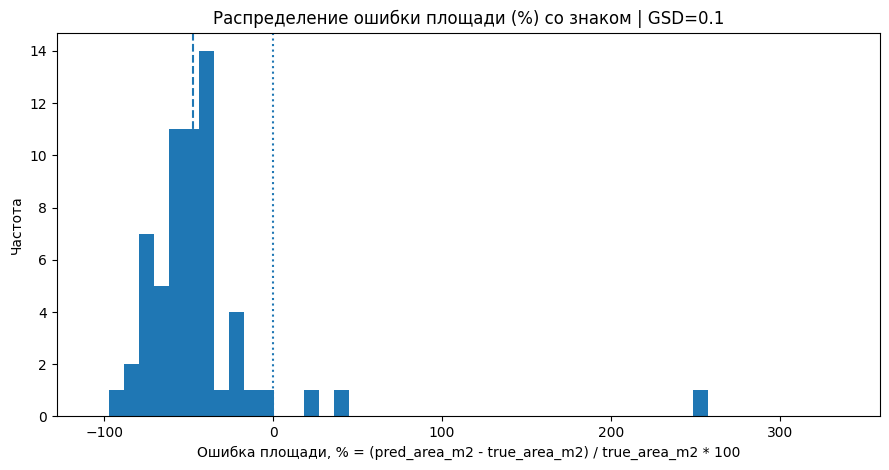

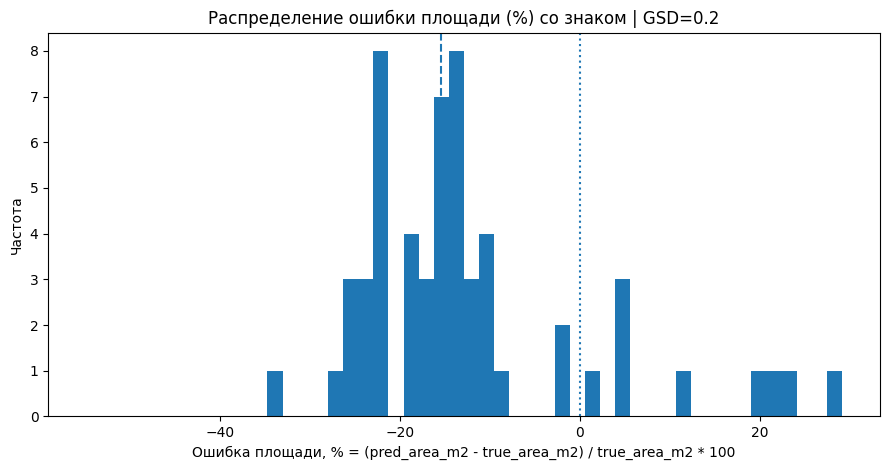

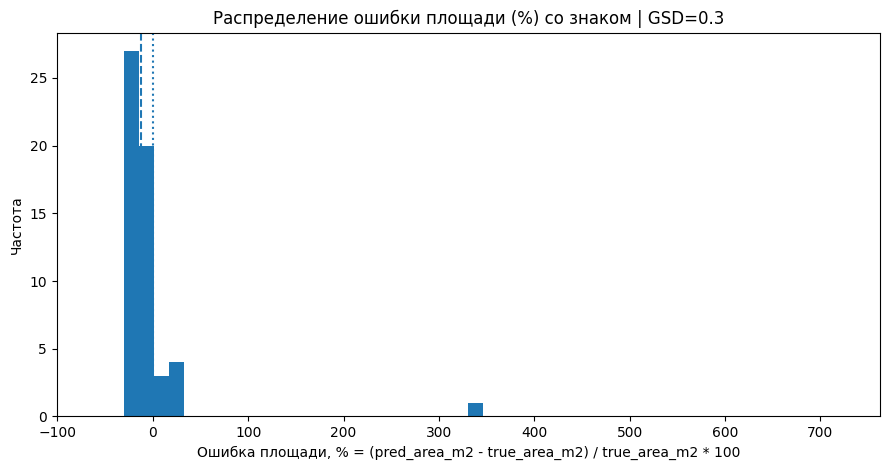

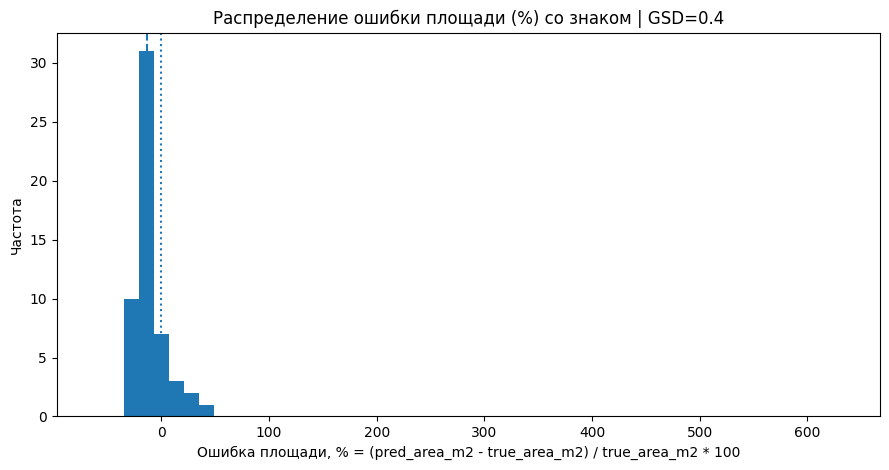

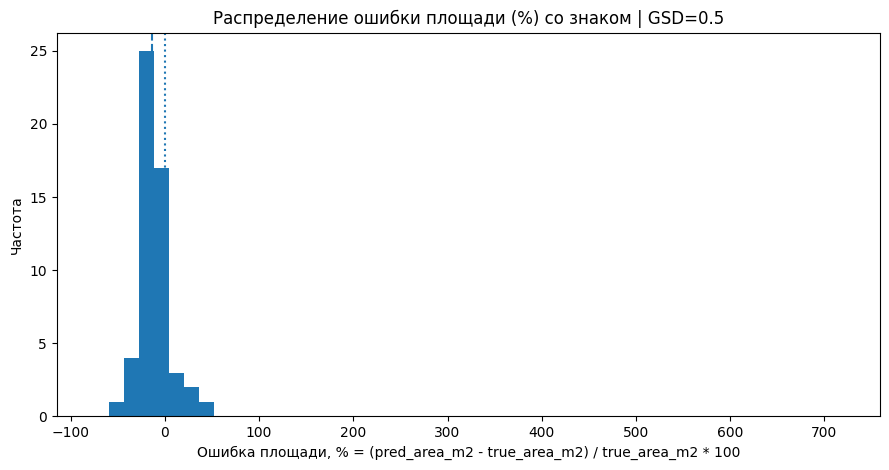

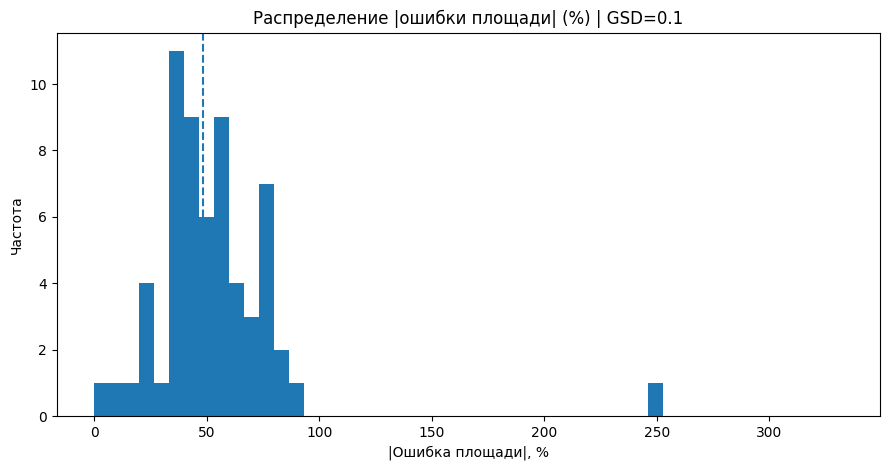

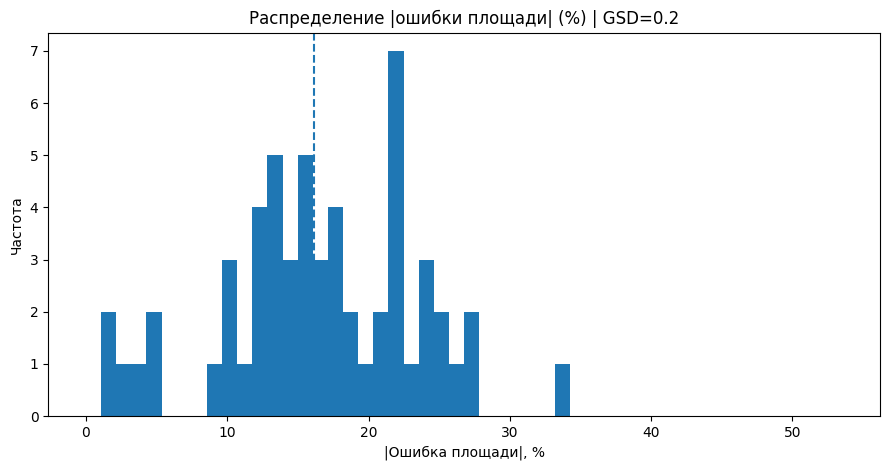

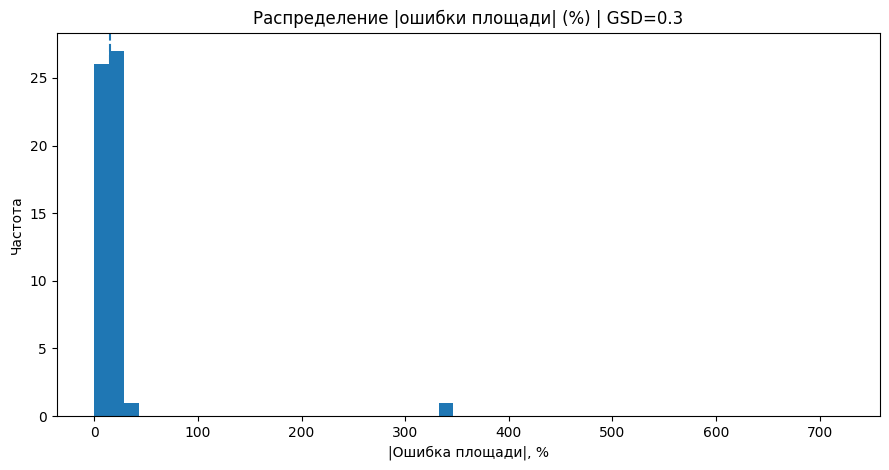

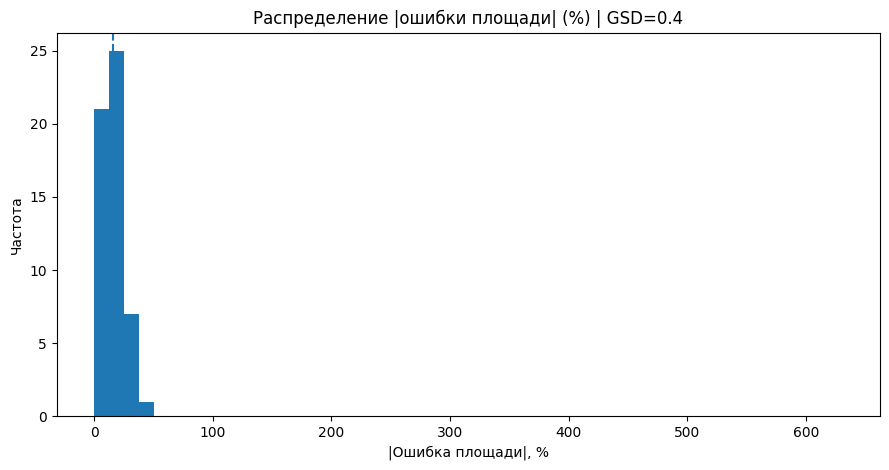

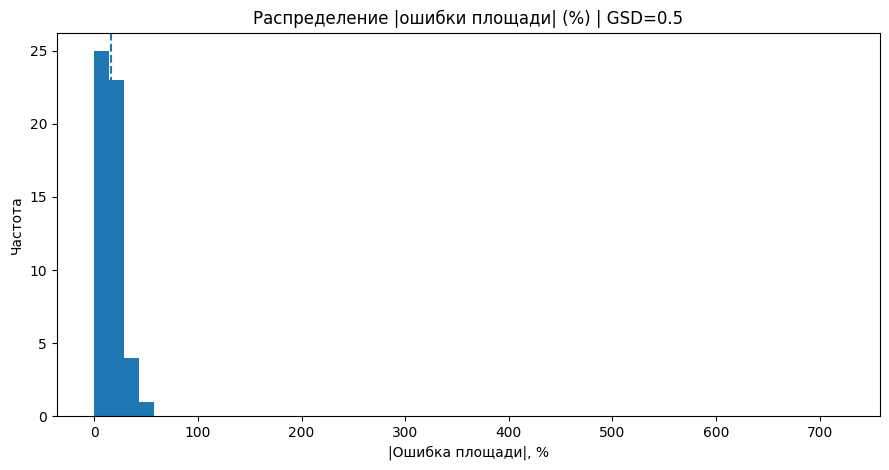

/tmp/ipython-input-3240966374.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_signed, labels=[str(g) for g in gsds], showfliers=False)


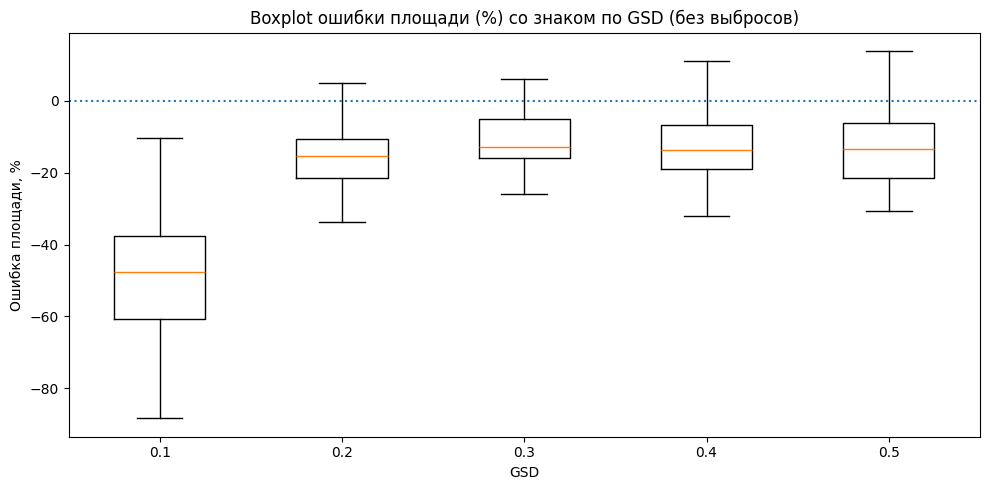

/tmp/ipython-input-3240966374.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_abs, labels=[str(g) for g in gsds], showfliers=False)


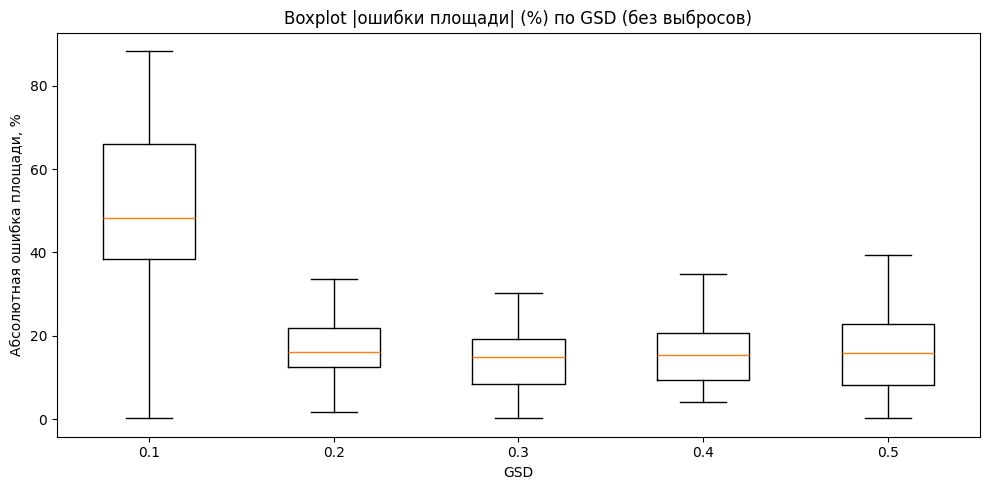

In [25]:
# ============================================================
# Графики распределения ошибки площади по каждому GSD
# Используем основной файл:
# /content/work/final_joined/segmentation_plus_gsd_plus_area.csv
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# ---------- 1) Путь к файлу ----------
CSV_PATH = "/content/work/final_joined/segmentation_plus_gsd_plus_area.csv"

# ---------- 2) Загружаем и приводим типы ----------
df = pd.read_csv(CSV_PATH)

# Числовые колонки — в numeric
num_cols = ["gsd", "gsd_pred", "true_area_m2", "pred_area_m2",
            "area_error_pct_signed", "area_error_pct_abs"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# gsd_ok нормализуем к bool
if "gsd_ok" in df.columns:
    if df["gsd_ok"].dtype != bool:
        df["gsd_ok"] = df["gsd_ok"].astype(str).str.lower().isin(["true", "1", "yes", "y"])
else:
    # если вдруг колонки нет — считаем ok, когда gsd_pred не NaN
    df["gsd_ok"] = df["gsd_pred"].notna()

# Фильтруем строки, где площадь определена и ошибка конечна
df_ok = df[
    (df["gsd_ok"] == True) &
    (df["true_area_m2"].notna()) &
    (df["true_area_m2"] > 0) &
    np.isfinite(df["area_error_pct_signed"])
].copy()

gsds = sorted(df_ok["gsd"].dropna().unique().tolist())
print("GSD в данных:", gsds)
print("Строк для графиков:", len(df_ok))

# ---------- 3) Удобные лимиты оси X (чтобы хвосты не убивали вид) ----------
def robust_limits(x, q_low=1, q_high=99):
    """
    Возвращает границы по перцентилям (по умолчанию 1..99),
    чтобы экстремальные выбросы не "сжимали" гистограмму.
    """
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return (-1, 1)
    lo = np.percentile(x, q_low)
    hi = np.percentile(x, q_high)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = float(np.min(x)), float(np.max(x))
    pad = 0.05 * (hi - lo) if (hi - lo) > 0 else 1.0
    return lo - pad, hi + pad

# ============================================================
# 4) Гистограммы ошибки площади (%) со знаком — по каждому GSD
# ============================================================

for g in gsds:
    x = df_ok.loc[df_ok["gsd"] == g, "area_error_pct_signed"].values
    x = x[np.isfinite(x)]
    if len(x) == 0:
        continue

    lo, hi = robust_limits(x, 1, 99)

    plt.figure(figsize=(9, 4.8))
    plt.hist(x, bins=50, range=(lo, hi))
    plt.axvline(np.median(x), linestyle="--")  # медиана
    plt.axvline(0, linestyle=":")              # нулевая ошибка
    plt.title(f"Распределение ошибки площади (%) со знаком | GSD={g}")
    plt.xlabel("Ошибка площади, % = (pred_area_m2 - true_area_m2) / true_area_m2 * 100")
    plt.ylabel("Частота")
    plt.tight_layout()
    plt.show()

# ============================================================
# 5) Гистограммы абсолютной ошибки площади (%) — по каждому GSD
# ============================================================

for g in gsds:
    x = df_ok.loc[df_ok["gsd"] == g, "area_error_pct_abs"].values
    x = x[np.isfinite(x)]
    if len(x) == 0:
        continue

    lo, hi = robust_limits(x, 1, 99)
    lo = max(lo, 0)  # абсолютная ошибка не должна уходить в минус

    plt.figure(figsize=(9, 4.8))
    plt.hist(x, bins=50, range=(lo, hi))
    plt.axvline(np.median(x), linestyle="--")  # медиана
    plt.title(f"Распределение |ошибки площади| (%) | GSD={g}")
    plt.xlabel("|Ошибка площади|, %")
    plt.ylabel("Частота")
    plt.tight_layout()
    plt.show()

# ============================================================
# 6) Сравнение по GSD одним взглядом: boxplot (без выбросов)
# ============================================================

# boxplot для signed ошибки
plt.figure(figsize=(10, 5))
data_signed = [df_ok.loc[df_ok["gsd"] == g, "area_error_pct_signed"].values for g in gsds]
plt.boxplot(data_signed, labels=[str(g) for g in gsds], showfliers=False)
plt.axhline(0, linestyle=":")
plt.title("Boxplot ошибки площади (%) со знаком по GSD (без выбросов)")
plt.xlabel("GSD")
plt.ylabel("Ошибка площади, %")
plt.tight_layout()
plt.show()

# boxplot для abs ошибки
plt.figure(figsize=(10, 5))
data_abs = [df_ok.loc[df_ok["gsd"] == g, "area_error_pct_abs"].values for g in gsds]
plt.boxplot(data_abs, labels=[str(g) for g in gsds], showfliers=False)
plt.title("Boxplot |ошибки площади| (%) по GSD (без выбросов)")
plt.xlabel("GSD")
plt.ylabel("Абсолютная ошибка площади, %")
plt.tight_layout()
plt.show()


Видно, что из-за высокой ошибки модели сегментации на большом апскейле (GSD 0,1) результаты на этом масштабе неудовлетворительны. На остальных масштабах от 0,2 до 0,3 большую роль в итоговой погрешности играет ошибка определения масштаба. Также видно, что масштаб хронически недооценен. Это происходит изза того что в тестовой выборке нет европейских городов с небольшими машинами, а преобладают американские города, где машины больше. Так как модель определения масштаба была обучена на размерах как европейских так и американских снимков, она систематически занижает GSD на снимках сделанных в США и наоборот завышает GSD на Европейских снимках.

Данный эффект может быть снижен если использовать разные модели для разных доменов. Также ошибку можно снизить путем добавления второй независимой модели определения масштаба на базе CNN.

Другой путь снижения ошибки добавление округления GSD до ближайшего значения по заданной сетке возможных масштабов (если заранее известны возможные значения GSD).